In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import mean_absolute_error
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from helper import *

In [2]:
con = sqlite3.connect('trade_info.sqlite3')

In [3]:
trading_session = pd.read_sql("SELECT * FROM trading_session", con)
chart_data = pd.read_sql("SELECT * FROM chart_data", con)

In [4]:
chart_data

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279
...,...,...,...,...,...,...
5503,5503,12:59:21,15,278,4611,1.946171
5504,5504,11:01:06,179,279,4612,1.128045
5505,5505,11:01:06,300,279,4613,1.128045
5506,5506,11:01:06,20,279,4614,1.128045


In [5]:
trading_session = trading_session.rename(columns={'id': "session_id"})
trading_session

,session_id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2
...,...,...,...,...
260,275,2021-06-22,daily,1
261,276,2021-06-22,daily,2
262,277,2021-06-23,monthly,1
263,278,2021-06-23,monthly,2


In [6]:
session_ids = chart_data['session_id'].to_list()
dates = pd.Series(trading_session.date.values,index=trading_session.session_id).to_dict()
dates_to_id = [dates[id_] if id_ in dates else np.nan for id_ in session_ids]

In [7]:
chart_data['date'] = dates_to_id

In [8]:
chart_data['datetime'] = [str(date) + ' ' + str(time) if date is not np.nan else np.nan for date, time in zip(chart_data['date'].to_list(), chart_data.time.to_list())]

In [9]:
chart_data['datetime'] = pd.to_datetime(chart_data['datetime'])

In [10]:
chart_data2 = chart_data.dropna()

In [11]:
monthly_ids = [id_ for id_, type_ in zip(trading_session['session_id'].to_list(), trading_session.trading_type.to_list()) if type_ == 'monthly']

In [12]:
monthly_data = chart_data[chart_data['session_id'].isin(monthly_ids)]

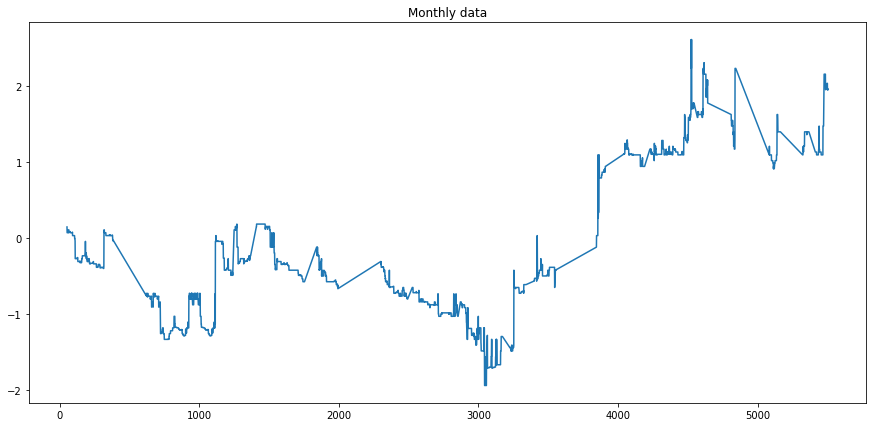

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(monthly_data['price'])
plt.title("Monthly data")
plt.show()

In [14]:
monthly_data

,id,time,lot_size,session_id,deal_id,price,date,datetime
53,53,11:04:47,21,27,53,0.143263,2019-10-24,2019-10-24 11:04:47
54,54,11:07:08,5,27,54,0.067510,2019-10-24,2019-10-24 11:07:08
55,55,11:07:08,3,27,55,0.067510,2019-10-24,2019-10-24 11:07:08
56,56,11:07:08,1,27,56,0.067510,2019-10-24,2019-10-24 11:07:08
57,57,11:07:08,1,27,57,0.067510,2019-10-24,2019-10-24 11:07:08
...,...,...,...,...,...,...,...,...
5499,5499,12:53:56,4,278,4607,2.029499,2021-06-23,2021-06-23 12:53:56
5500,5500,12:59:08,159,278,4608,1.946171,2021-06-23,2021-06-23 12:59:08
5501,5501,12:59:08,38,278,4609,1.953746,2021-06-23,2021-06-23 12:59:08
5502,5502,12:59:08,42,278,4610,1.961322,2021-06-23,2021-06-23 12:59:08


#### Представим каждую сессию в виде вектора из цены на каждую минуту

(смотрим помесячные сессии)

In [15]:
embeddings = make_embeddings(monthly_data)

In [16]:
print(f'Всего месячных сессий {embeddings.shape[0]} штуки')
print(f'Размер поминутных эмбеддингов {embeddings.shape[1]}')

Всего месячных сессий 52 штуки
Размер поминутных эмбеддингов 60


Посмотрим для примера косинусное расстояние между первыми пятью сессиями:

In [17]:
pretty_print(cosine_distances(embeddings[:5, :5]))

-	0	1	2	3	4	
0	0.0	1.0	1.0	1.0	1.0	
1	1.0	0.0	1.99	1.83	2.0	
2	1.0	1.99	0.0	0.19	0.01	
3	1.0	1.83	0.19	0.0	0.17	
4	1.0	2.0	0.01	0.17	0.0	


#### DBScan на косинусном расстоянии

In [18]:
dbscan = DBSCAN(metric='cosine').fit(embeddings)

In [19]:
dbscan.labels_

array([ 0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

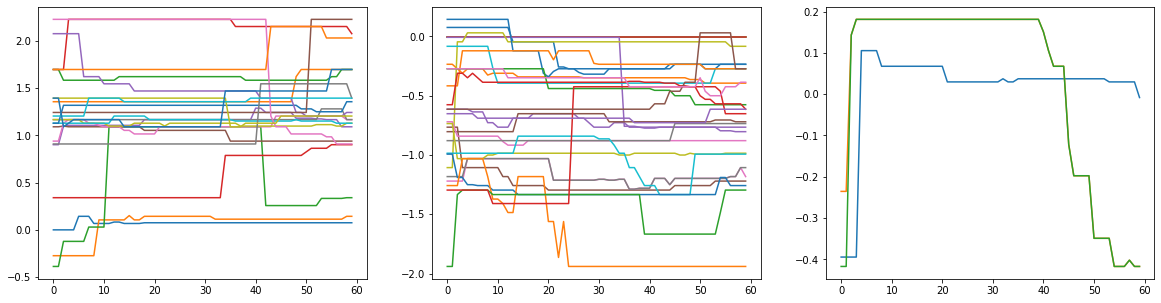

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for emb in embeddings[np.where(dbscan.labels_ == 0)[0]]:
    axs[0].plot(emb)
for emb in embeddings[np.where(dbscan.labels_ == 1)[0]]:
    axs[1].plot(emb)
for emb in embeddings[np.where(dbscan.labels_ == -1)[0]]:
    axs[2].plot(emb)

Косинусное расстояние дает два кластера и три выброса. Внутри кластера 0 находятся преимущественно сессии, в которых цена со временем возрастала. В кластере 1 преимущественно сессии, где цена со временем падала.

#### DBScan на метрике DTW

In [21]:
dbscan_dtw = DBSCAN(metric=dtw.distance).fit(embeddings)

In [22]:
dbscan_dtw.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

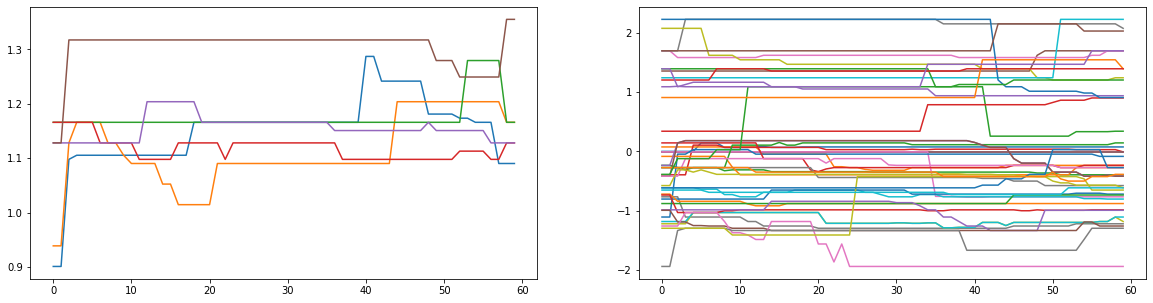

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for emb in embeddings[np.where(dbscan_dtw.labels_ == 0)[0]]:
    axs[0].plot(emb)
for emb in embeddings[np.where(dbscan_dtw.labels_ == -1)[0]]:
    axs[1].plot(emb)

Кластеризация по метрике DTW дала один кластер с не очень похожими друг на друга сессиями, а все остальное попало в выбросы. Получилось плохо :с

#### DBScan на метрике DTW с нормализованными строчками эмбеддингов

Нормализация нужна для того, чтобы цена варьировалась от 0 до 1 и сохранялся только тренд ее колебаний.

In [24]:
norm_emb = normalise(embeddings)

In [25]:
dbscan_dtw_norm = DBSCAN(metric=dtw.distance).fit(norm_emb)

In [26]:
dbscan_dtw.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

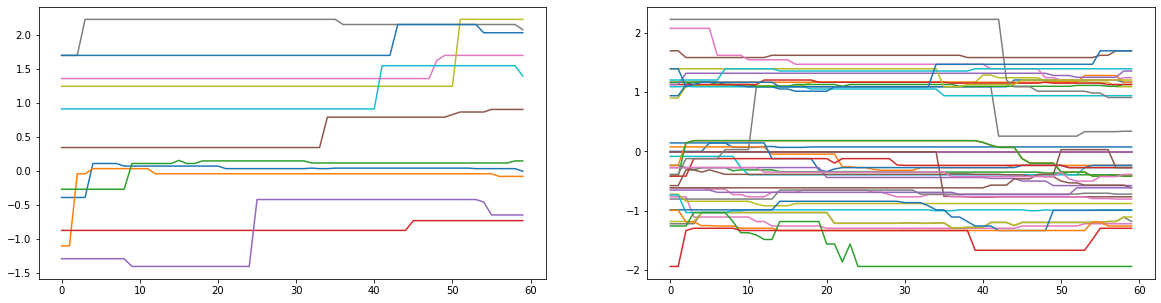

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for emb in embeddings[np.where(dbscan_dtw_norm.labels_ == 0)[0]]:
    axs[0].plot(emb)
for emb in embeddings[np.where(dbscan_dtw_norm.labels_ == -1)[0]]:
    axs[1].plot(emb)

Кажется, нормализация помогла улучшить результат в кластере 0, так как теперь там находятся сессии, в которых цена сначала была стабильной, а потом возрастала. Однако больше кластеров не нашлось и все остальное попало в выбросы.

#### DBScan на метрике MAE

In [28]:
dbscan_mae = DBSCAN(metric=mean_absolute_error).fit(embeddings)

In [29]:
dbscan_mae.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1])

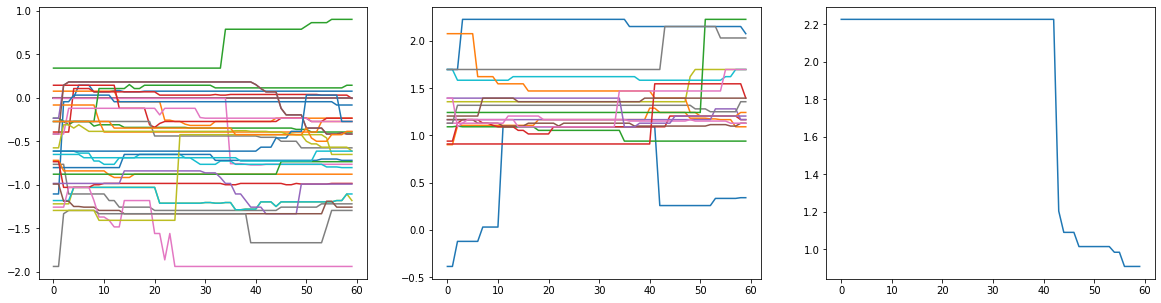

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for emb in embeddings[np.where(dbscan_mae.labels_ == 0)[0]]:
    axs[0].plot(emb)
for emb in embeddings[np.where(dbscan_mae.labels_ == 1)[0]]:
    axs[1].plot(emb)
for emb in embeddings[np.where(dbscan_mae.labels_ == -1)[0]]:
    axs[2].plot(emb)

MAE дало два кластера и один выброс. Результат похож на результат косинусного расстояния: в кластере 0 находятся преимущественно сессии, в которых цена со временем падала, а в кластере 1 -- те, где цена со временем возрастала. Но в целом все же кластеры по большей части очень смешанные и очень явных трендов не видно.